# SNN with hierarchy of Time constant
---
This notebook is mainly for developing the code that will be rewritten in python files\\

The idea is to explore what role a hierarchy of time scales have in temporal processing, especially when dealing with multi-time-scale inputs.\\

Prior literature shows the importance of heterogeneity of time scales in SNNs, mainly showing that diversity of time-scales are beneficial.
- https://www.nature.com/articles/s41467-021-26022-3
- https://www.nature.com/articles/s41467-023-44614-z

However, an interpretation of the role of the hierarchy of time constant is still missing.

The assumption is that when treating a temporal sequence sempled at a certain period $\tau_{sampling}$ and with a total duration $\Tau$, there can be an optimal sequence of filters $F_i(\tau_i)$ that process the input sequence. For each of the filters $\tau_{i+1} > \tau_i$, where the subscript indicates the order of the filter. More simply, there is a hierarchy of time-scales - from fast to slow - that leads to an optimal processing of the input sequence.

In [1]:
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers

import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random

from jax import vmap, jit, value_and_grad, local_device_count
from jax.example_libraries import optimizers
from jax.lax import scan, cond
import pickle

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".25" # needed because network is huge
os.environ["CUDA_VISIBLE_DEVICES"]="0"
jax.devices()

I0000 00:00:1711468529.304967       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


[CpuDevice(id=0)]

# Hyperparameter sweep
---
performed with WandB

In [ ]:
import wandb
wandb.login()

## Parameters of the SNN model
---

In [3]:
from utils_initialization import SimArgs
args = SimArgs()

## Training function
---

In [4]:
from training import train_hsnn_wandb

# Sweep Configuration

In [5]:
sweep_config = {
    'method': 'grid',
}

metric = {
    'name': 'accuracy',
    'goal': 'maximize'
    }
sweep_config['metric'] = metric

config = {}
for i, [key, value] in enumerate( zip( args.__dict__.keys(), args.__dict__.values()  ) ):
    config[key] = {'value': value}
# update the parameters to sweep
config['tau_mem'] = {'values':[0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.8]}
config['seed'] = {'values':[0]}
config['n_epochs'] = {'value':5}
config['n_layers'] = {'value':4}

sweep_config['parameters'] = config

In [6]:
sweep_id = wandb.sweep(sweep_config, project="Tau_mem_short")

Create sweep with ID: qa0lo9cv
Sweep URL: https://wandb.ai/filomo14/Tau_mem_short/sweeps/qa0lo9cv


In [ ]:
wandb.agent(sweep_id, train_hsnn_wandb)

# Single Round
---
We'll use Leaky-Integrate-and-Fire neurons for the Hidden layers, Leaky-Integrator neurons for the output.

We also define some additional functions to: Introduce Noise in Weights and Membrane voltage, Introduce the Surrogate Gradient function.

In [2]:
from models import *
from utils_initialization import *
from training import *

In [4]:
args.train_alpha = False
args.hierarchy_tau = True
args.distrib_tau = True
args.recurrent = False
args.normalizer = 'batch' # 'batch' #'layer'
args.n_layers = 2
# time constants
args.tau_mem = 0.1 #0.1
args.delta_tau = 0.075

# LR and regularizers
if args.recurrent: args.lr = 0.01
else: args.lr = 0.01
args.lr_decay = 0.5
args.lr_decay_every = 50
args.l2_lambda = 0 #1e-6
args.freq_lambda = 0 #1e-6
args.dropout_rate = 0.1
args.n_epochs = 10
args.lr = 0.005
args.decoder = 'cum'
args.dataset_name = 'ssc'
args.n_out = 20 if args.dataset_name == 'shd' else 35  # output channels

# Training
train_loss, test_acc, val_acc, net_params_best = train_hsnn( args = args )

Train DL size: 75466, Validation DL size: 9981, Test DL size: 20382
Epoch: [1/10] - Loss: 1.29161 -  Training acc: 14.89 - Validation acc: 20.74 - t: 29.32 sec
Epoch: [2/10] - Loss: 1.11695 -  Training acc: 20.33 - Validation acc: 21.97 - t: 27.23 sec
Epoch: [3/10] - Loss: 0.97103 -  Training acc: 21.53 - Validation acc: 22.58 - t: 26.77 sec
Epoch: [4/10] - Loss: 1.06571 -  Training acc: 22.16 - Validation acc: 22.43 - t: 26.38 sec
Epoch: [5/10] - Loss: 0.94840 -  Training acc: 22.71 - Validation acc: 24.02 - t: 26.56 sec
Epoch: [6/10] - Loss: 0.71240 -  Training acc: 23.30 - Validation acc: 27.15 - t: 26.98 sec
Epoch: [7/10] - Loss: 0.66126 -  Training acc: 29.43 - Validation acc: 30.60 - t: 26.87 sec
Epoch: [8/10] - Loss: 0.86655 -  Training acc: 31.04 - Validation acc: 30.94 - t: 27.42 sec
Epoch: [9/10] - Loss: 0.79230 -  Training acc: 31.60 - Validation acc: 31.47 - t: 27.20 sec
Epoch: [10/10] - Loss: 0.69833 -  Training acc: 32.17 - Validation acc: 32.30 - t: 26.59 sec
Validation 

In [5]:
args.n_out

35

0.5624054
0.87467754
0.9415965


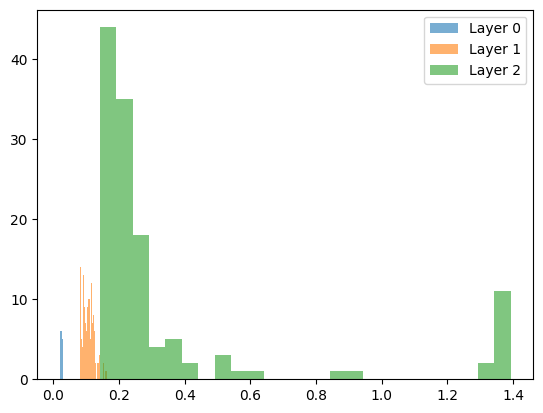

: 

In [4]:
import matplotlib.pyplot as plt
for i in range(args.n_layers-1):
    # _ = plt.hist( net_params_best[i][1], 25, alpha=0.6, label=f'Layer {i}' )
    _ = plt.hist( - args.timestep / np.log( net_params_best[i][1] ), 25, alpha=0.6, label=f'Layer {i}' )
    print( np.mean(  net_params_best[i][1] ) )
plt.legend()

# HSNN analysis
---
Here we take a pre-trained model and analyze its performance, trying to understand "how" and "why" it performs well.

In [309]:
# Import model
import pickle, os
dir_models = '/Users/filippomoro/Documents/hsnn/results'
model_path = 'Hierarchy_tau_mem100_delta_tau90_seed0'
model_name = os.path.join( model_path, 'model.pkl' )
file_name = os.path.join( dir_models, model_name ) 
loaded_model = pickle.load( open( file_name, 'rb' ) )
args = loaded_model['args']
net_params_best = loaded_model['net_params_best']

In [313]:
loaded_model['val_acc']

Array(97.05882, dtype=float32)

In [12]:
# Load the test set of the dataset
from utils_dataset import get_dataloader
_, _, test_dl = get_dataloader( args=args, verbose=True )

Train DL size: 8156, Validation DL size: 1632, Test DL size: 2264


In [13]:
from utils_initialization import params_initializer, SimArgs
from utils_normalization import LayerNorm, BatchNorm
from models import lif_step, rlif_step, li_step, dropout
from models import decoder_cum, decoder_freq, decoder_sum, decoder_vlast, decoder_vmax

# selecting the right decoder
decoder_dict = {'cum'  : decoder_cum,
                'sum'  : decoder_sum,
                'vmax' : decoder_vmax,
                'vlast': decoder_vlast,
                'freq' : decoder_freq
                }
if args.decoder in decoder_dict.keys():
    decoder = decoder_dict[args.decoder]
else: 
    print('Unrecognized Decoder, will revert to a "cum"-style decoder')
    print('Next time choose a decoder in: '+str(list(decoder_dict.keys())))
    args.decoder = 'cum'
    decoder = decoder_dict[args.decoder]

# network architecture
if args.recurrent:
    layer = rlif_step
else: 
    layer = lif_step
if args.decoder == 'freq':
    layer_out = lif_step
else: 
    layer_out = li_step
if args.normalizer == 'batch': norm = BatchNorm
elif args.normalizer == 'layer': norm = LayerNorm
else: norm = None

In [24]:
from jax import jit, vmap

@jit
def scan_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer = vmap( scan_layer, in_axes=(None, 0))

@jit
def scan_out_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer_out, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer_out = vmap( scan_out_layer, in_axes=(None, 0))

# the following function implements the main network
@jit
def hsnn( args_in, input_spikes ):
    net_params, net_states, key, dropout_rate = args_in # input arguments
    n_layers = len( net_params )                        # umber of layers
    # collection of output spikes
    out_spike_net = [] # collects the spikes from each layer
    # Loop over the layers
    for l in range(n_layers):
        # selecting the right input (from the previous layer)
        if l == 0: layer_input_spike = input_spikes
        else: layer_input_spike = out_spikes_layer
        # making layers' params and states explitic
        # parameters (weights and alpha) and the state of the neurons (spikes, inputs and membrane, ecc..)
        w, alpha = net_params[l]; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states[l]
        if len(w) == 3: # it means that we'll do normalization
            weight, scale, bias = w
        else: weight = w
        if len(weight) ==2: weight, _ = weight
        # Multiplying the weights by the spikes
        I_in = jnp.matmul(layer_input_spike, weight)
        # Normalization (if selected)
        if len(w) == 3: # it means that we'll do normalization
            b, t, n = I_in.shape
            I_in = norm( I_in.reshape( b*t, n ), bias = bias, scale = scale )
            I_in = I_in.reshape( b,t,n ) # normalized input current
        # Forward pass of the Layer
        args_in_layer = [net_params[l], net_states[l]]
        if l+1 == n_layers:
            _, out_spikes_layer = vscan_layer_out( args_in_layer, I_in )
        else: 
            _, out_spikes_layer = vscan_layer( args_in_layer, I_in )
            # Dropout
            key, key_dropout = jax.random.split(key, 2)
            out_spikes_layer = dropout( key_dropout, out_spikes_layer, rate=dropout_rate, deterministic=False )
        out_spike_net.append(out_spikes_layer)
    return out_spikes_layer, out_spike_net

def one_hot(x, n_class):
    return jnp.array(x[:, None] == jnp.arange(n_class), dtype=jnp.float32)

### Perform inference with the Test set and check the spiking-activity of the network

In [186]:
def run_inference( loaded_model ):
    args = loaded_model['args']
    net_params_best = loaded_model['net_params_best']

    # Initialize states
    _ , net_states = params_initializer(key=jax.random.PRNGKey(args.seed), args=args)

    # Take a new batch
    x_test, y_test = next(iter( test_dl ))

    # Inference
    dropout_rate = 0.
    key=jax.random.PRNGKey(args.seed)
    args_in = [net_params_best, net_states, key, dropout_rate]
    output_layer, out_spike_net = hsnn( args_in, x_test ) # ------------> OUT_SPIKE_NET is what we're after
    Yhat = decoder( output_layer )
    # compute the loss and correct examples
    Y_test = one_hot( y_test, 20 )
    num_correct = jnp.sum(jnp.equal(jnp.argmax(Yhat, 1), jnp.argmax(Y_test, 1)))
    # cross entropy loss
    loss_ce = -jnp.mean( jnp.sum(Y_test * jnp.log(Yhat+1e-12), axis=-1) )
    # L2 norm
    loss_l2 = optimizers.l2_norm( [net_params_best[l][0] for l in range(len(net_params_best))] ) * args.l2_lambda
    # firing rate loss
    avg_spikes_neuron = jnp.mean( jnp.stack( [ jnp.mean( jnp.sum( out_spike_net[l], axis=1 ), axis=(0,-1) ) for l in range( len(net_params_best)-1 )] ) )
    loss_fr = args.freq_lambda * (args.target_fr - avg_spikes_neuron)**2
    # Total loss
    loss_total = loss_ce + loss_l2 + loss_fr
    loss_values = [num_correct, loss_ce]
    return out_spike_net

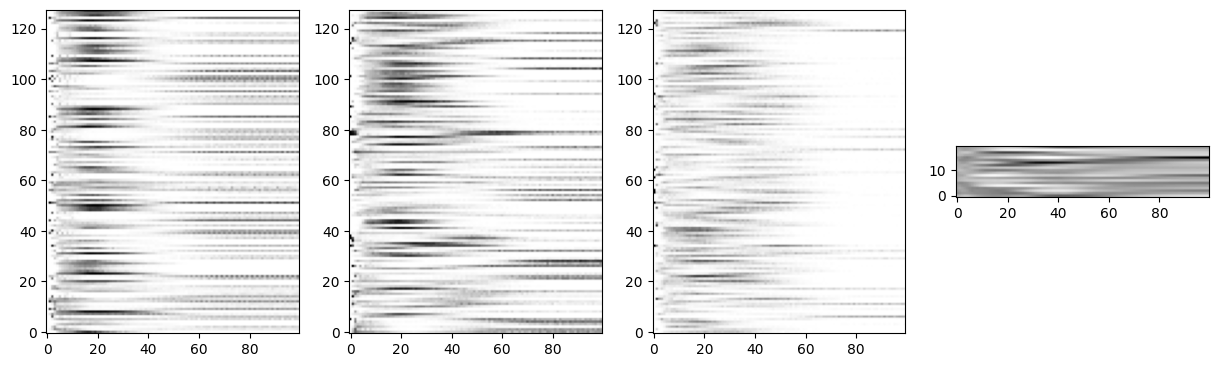

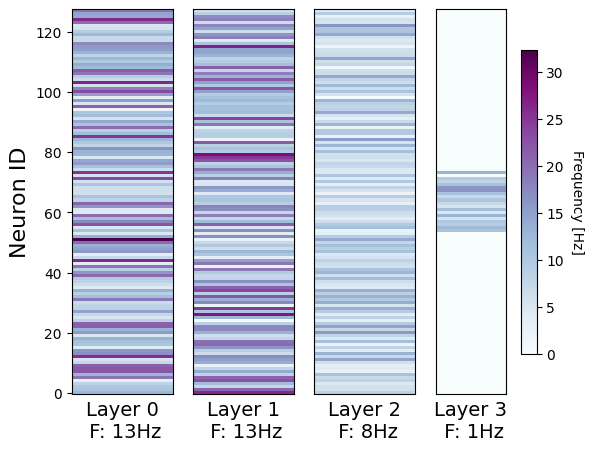

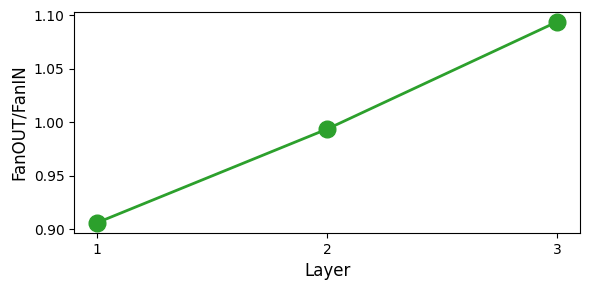

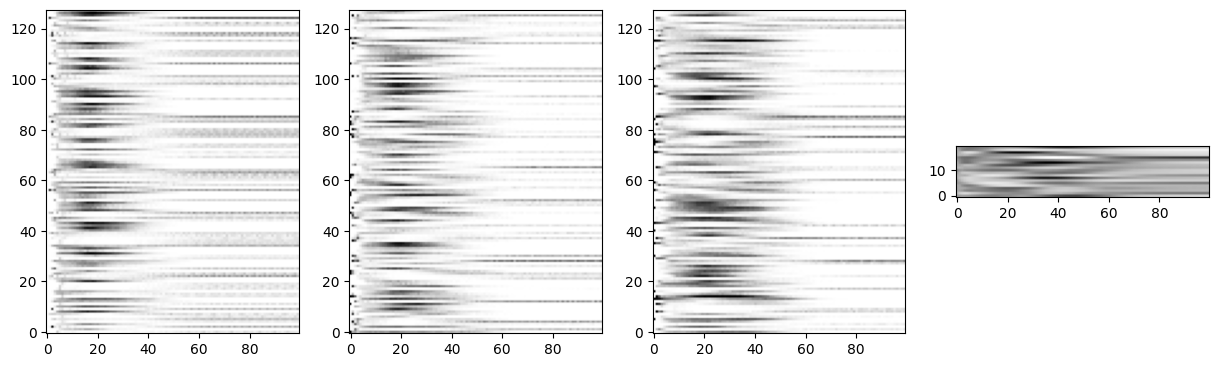

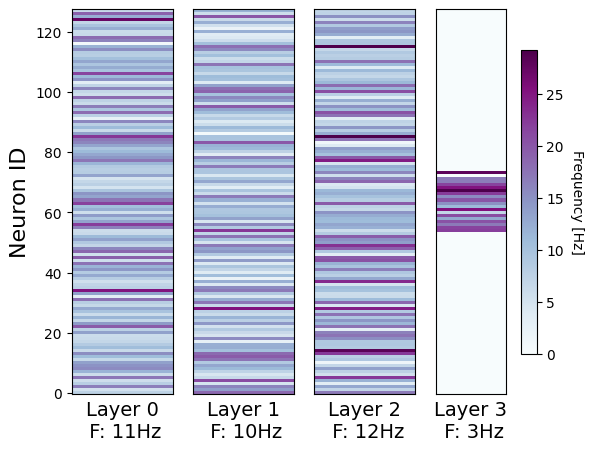

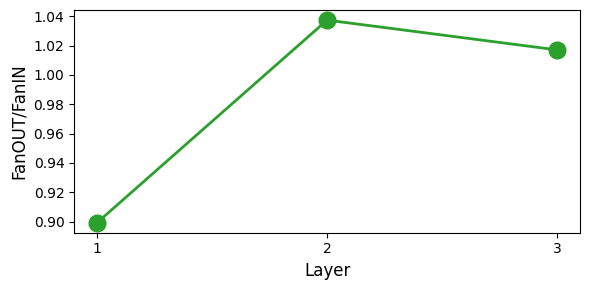

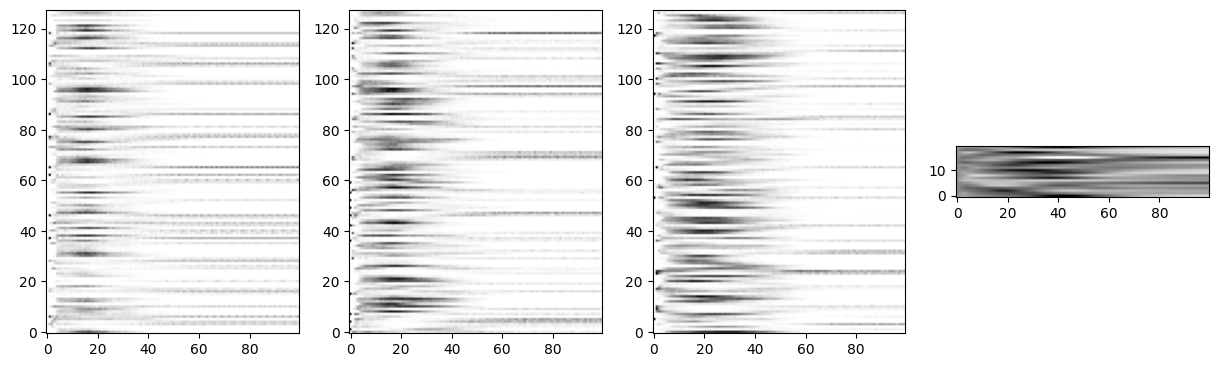

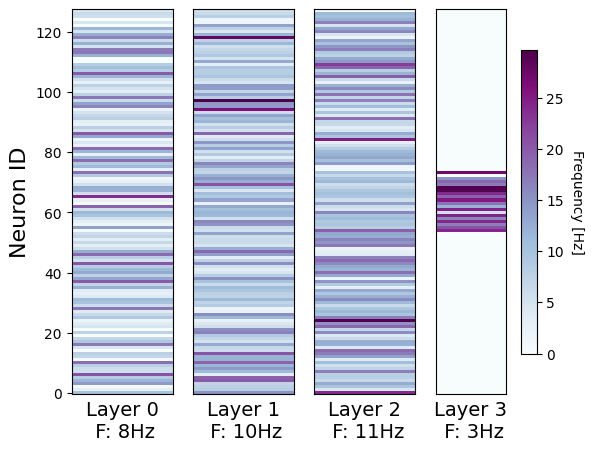

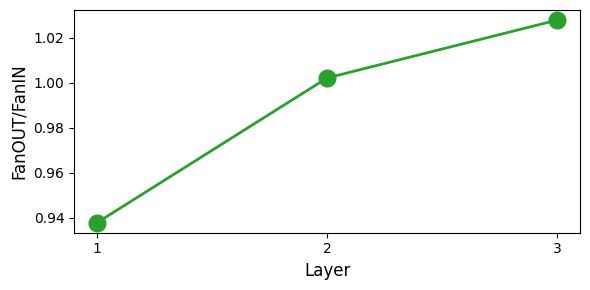

In [251]:
model_paths = ['Hierarchy_tau_mem100_delta_tau-90_seed0', 
               'Hierarchy_tau_mem100_delta_tau0_seed0', 
               'Hierarchy_tau_mem100_delta_tau90_seed0']
spiking_activity_models = []

for m, model_path in enumerate( model_paths ):
    model_name = os.path.join( model_path, 'model.pkl' )
    file_name = os.path.join( dir_models, model_name )
    loaded_model = pickle.load( open( file_name, 'rb' ) )
    out_spike_net = run_inference( loaded_model )

    # Computing Fan-in Fan-out
    FanIN, FanOUT = [], []
    for i in range( args.n_layers-1 ):
        FanIN.append( np.abs( loaded_model['net_params_best'][i][0][0] ).mean(0) )
        FanOUT.append( np.abs( loaded_model['net_params_best'][i+1][0][0] ).mean(1) )
    FanIN = np.array( FanIN ); FanOUT = np.array( FanOUT )

    # collecting the spiking activity
    spiking_activity = []
    for i in range( args.n_layers ):
        # print( f'Layer {i+1}, spiking frequency: {out_spike_net[i].mean()*args.timestep**-1:.2f}Hz' )
        if i == args.n_layers-1:
            mean_spk = 0. #out_spike_net[0].mean( ).reshape(-1,1) *args.timestep**-1
            padded_spikes = np.pad( out_spike_net[i].mean( axis=(0,1) ) + np.abs( out_spike_net[i].mean( axis=(0,1) ).min() ), 
                                pad_width=( int( (args.n_hid-20)/2) ), constant_values=(mean_spk) ).reshape(-1,1)
            padded_spikes = ( padded_spikes / padded_spikes.max() ) * spiking_activity[-1].max()
            spiking_activity.append( padded_spikes )
        else:
            spiking_activity.append( out_spike_net[i].mean( axis=(0,1) ).reshape(-1,1) *args.timestep**-1 )
    spiking_activity = np.hstack( spiking_activity ).T
    spiking_activity_models.append(spiking_activity)

    # Plotting the spiking activity
    fig, ax = plt.subplots( 1, args.n_layers, figsize=( 15,10 ) )
    fig2, ax2 = plt.subplots( 1, args.n_layers, figsize=( 6,5 ) )
    for i in range( args.n_layers ):
        ax[i].imshow( out_spike_net[i].mean( axis=(0) ).T, cmap='Grays', origin='lower' )
        im = ax2[i].imshow( spiking_activity[i].reshape(-1,1), aspect='auto', cmap='BuPu',
                            vmin=0, vmax=spiking_activity.flatten().max(), origin='lower' )
        ax2[i].set_xticks( [] ); ax2[i].set_xlabel(f'Layer {i}\n F: {spiking_activity[i].mean():.0f}Hz', size=14)
        if i != 0: ax2[i].set_yticks([])
        else: ax2[i].set_ylabel( 'Neuron ID', size=16 )
    cbar = fig.colorbar(im, ax=ax2[i], pad=0.15)
    cbar.ax.set_ylabel('Frequency [Hz]', rotation=-90, va="bottom")

    # Plotting the FanIN/FanOUT
    figF, axF = plt.subplots( figsize=(6,3) )
    axF.plot( np.mean(FanOUT/FanIN, axis=1), color='tab:green', marker='o', ms=12, lw=2 )
    axF.set_xticks( np.arange( args.n_layers-1 ), np.arange( args.n_layers-1 )+1 )
    axF.set_ylabel( 'FanOUT/FanIN', size=12 )
    axF.set_xlabel( 'Layer', size=12 )
    
    plt.tight_layout()
    plt.show()

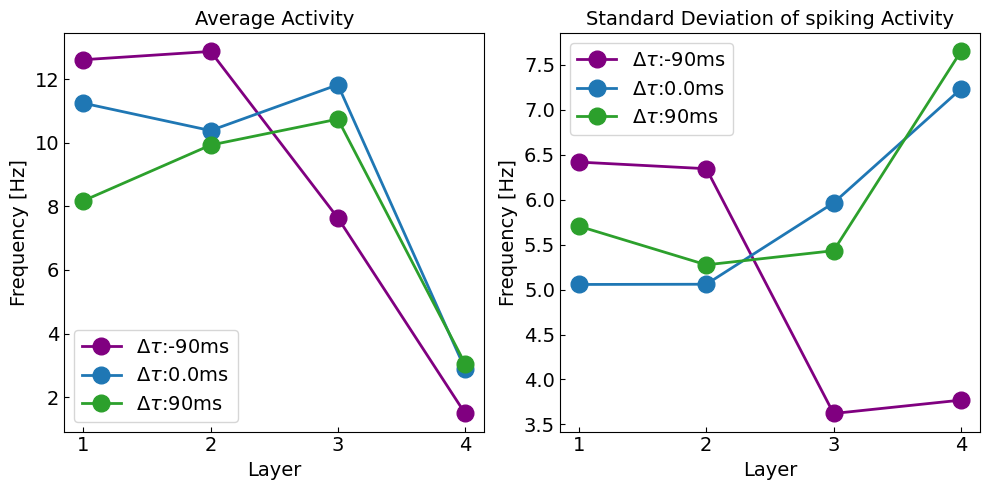

In [211]:
fig_freq, ax = plt.subplots( 1,2, figsize=(10,5) )
# plotting the aerage frequency per layer, for the different models
deltas = [-90, 0., 90]
colors  = ['purple', 'tab:blue', 'tab:green']
for s, spiking_activity in enumerate( spiking_activity_models ):
    ax[0].plot( [spiking_activity[i].mean() for i in range(args.n_layers)], 
                color=colors[s], label=r'$\Delta \tau$:'+str(deltas[s])+'ms',
                marker='o', ms=12, lw=2 )
    ax[1].plot( [spiking_activity[i].std() for i in range(args.n_layers)], 
                color=colors[s], label=r'$\Delta \tau$:'+str(deltas[s])+'ms',
                marker='o', ms=12, lw=2 )
[ax[i].set_xticks( np.arange( args.n_layers ), np.arange( args.n_layers )+1 ) for i in range(len(ax))]
[ax[i].set_xlabel( 'Layer', size=14 ) for i in range(len(ax))]
[ax[i].set_ylabel( 'Frequency [Hz]', size=14 ) for i in range(len(ax))]
[ax[i].legend(prop={'size':14}) for i in range(len(ax))]
[ax[i].tick_params( labelsize=14, direction='in' ) for i in range(len(ax))]
ax[0].set_title( 'Average Activity', size=14 )
ax[1].set_title( 'Standard Deviation of spiking Activity', size=14 )
plt.tight_layout()

# Hyperparameter Tuning / Early Analysis
---


- No Hierarchy, what is the best Time Constant for a 4 layers network?

In [3]:
### time constant
# load file
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
file_dir = '/Users/filippomoro/Documents/hsnn/results'
file_name = os.path.join( file_dir, 'Sweep_tau_mem_wandb_export_2024-03-25T09_22_38.384+01_00.csv' )
df = pd.read_csv( file_name, delimiter=',' )

tau_mem_list = np.sort( list( set( list(df['tau_mem'] ) ) ) )

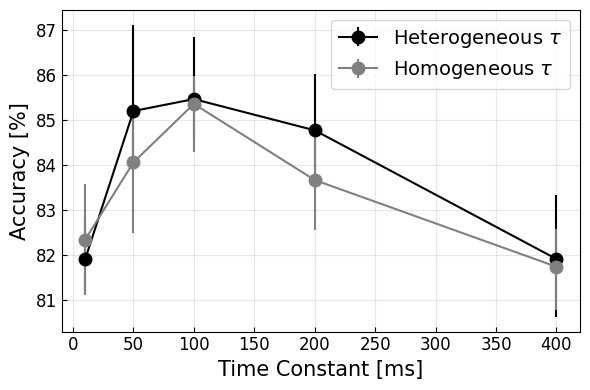

In [141]:
### time constant sweep
# load file
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
file_dir = '/Users/filippomoro/Documents/hsnn/results'
file_name = os.path.join( file_dir, 'Sweep_tau_mem_wandb_export_2024-03-25T09_22_38.384+01_00.csv' )
df = pd.read_csv( file_name, delimiter=',' )

tau_mem_list = np.sort( list( set( list(df['tau_mem'] ) ) ) )[:-1]
# With Heterogeneity of Time constant
mean_acc_tau_mem = np.array( [ df['Test Acc'][df['tau_mem']==tau][df['distrib_tau']==True].mean() for tau in tau_mem_list] )
max_acc_tau_mem = np.array( [ df['Test Acc'][df['tau_mem']==tau][df['distrib_tau']==True].quantile(0.85) for tau in tau_mem_list] )
min_acc_tau_mem = np.array( [ df['Test Acc'][df['tau_mem']==tau][df['distrib_tau']==True].quantile(0.15) for tau in tau_mem_list] )
# With Homogeneity of Time constant
mean_acc_tau_mem_hom = np.array( [ df['Test Acc'][df['tau_mem']==tau][df['distrib_tau']==False].mean() for tau in tau_mem_list] )
max_acc_tau_mem_hom = np.array( [ df['Test Acc'][df['tau_mem']==tau][df['distrib_tau']==False].quantile(0.85) for tau in tau_mem_list] )
min_acc_tau_mem_hom = np.array( [ df['Test Acc'][df['tau_mem']==tau][df['distrib_tau']==False].quantile(0.15) for tau in tau_mem_list] )

fig, ax = plt.subplots( figsize=(6,4) )
# With Heterogeneity of Time constant
# ax.plot( tau_mem_list*1e3, mean_acc_tau_mem, color='k', marker='o', ms=9, label=r'Heterogeneous $\tau$' )
# ax.fill_between( tau_mem_list*1e3, min_acc_tau_mem, max_acc_tau_mem, color='k', alpha=0.2 )
yerr_list = [mean_acc_tau_mem-min_acc_tau_mem, max_acc_tau_mem-mean_acc_tau_mem]
hierarchy_plot = ax.errorbar( tau_mem_list*1e3, mean_acc_tau_mem, yerr=yerr_list,
                color='k', marker='o', ms=9, 
                label=r'Heterogeneous $\tau$')
# With Homogeneity of Time constant
# ax.plot( tau_mem_list*1e3, mean_acc_tau_mem_hom, color='gray', marker='^', ms=9, label=r'Homogeneous $\tau$' )
# ax.fill_between( tau_mem_list*1e3, min_acc_tau_mem_hom, max_acc_tau_mem_hom, color='gray', alpha=0.1 )
yerr_list = [mean_acc_tau_mem_hom-min_acc_tau_mem_hom, max_acc_tau_mem_hom-mean_acc_tau_mem_hom]
hierarchy_plot = ax.errorbar( tau_mem_list*1e3, mean_acc_tau_mem_hom, yerr=yerr_list,
                color='gray', marker='o', ms=9, 
                label=r'Homogeneous $\tau$')
# plot setting
ax.set_xlabel('Time Constant [ms]', size=15); ax.set_ylabel('Accuracy [%]', size=15)
ax.tick_params( direction='in', labelsize=12 )
ax.legend(prop={'size':14})
ax.grid(alpha=0.3)
plt.tight_layout()
fig.savefig( os.path.join( os.getcwd(), 'results/Tau_mem_sweep.pdf' ), dpi=300, transparent=True )

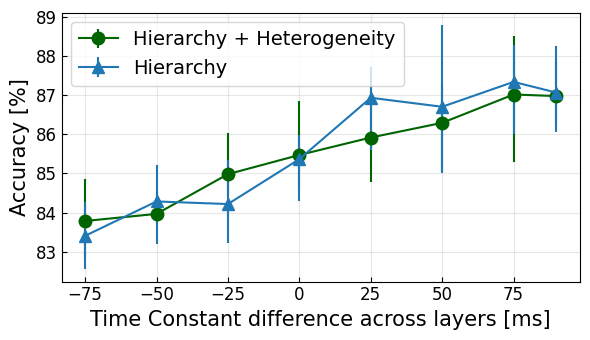

In [140]:
### delta tau --> hierarchical
# load file
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
file_dir = '/Users/filippomoro/Documents/hsnn/results'
file_name = os.path.join( file_dir, 'Sweep_delta_tau_wandb_export_2024-03-25T09_21_13.935+01_00.csv' ) # Sweep_delta_tau_wandb_export_2024-03-25T09_21_13.935+01_00
df = pd.read_csv( file_name, delimiter=',' )

delta_tau_list = np.sort( list( set( list(df['delta_tau'] ) ) ) )
# delete two unnecessary datapoints
delta_tau_list = np.delete( delta_tau_list, delta_tau_list==0.001 )
delta_tau_list = np.delete( delta_tau_list, delta_tau_list==-0.001 )
# Heterogeneity
mean_acc_delta_tau = np.array( [ df['Test Acc'][df['delta_tau']==tau][df['distrib_tau']==True].mean() for tau in delta_tau_list] )
max_acc_delta_tau = np.array( [ df['Test Acc'][df['delta_tau']==tau][df['distrib_tau']==True].quantile(0.85) for tau in delta_tau_list] )
min_acc_delta_tau = np.array( [ df['Test Acc'][df['delta_tau']==tau][df['distrib_tau']==True].quantile(0.15) for tau in delta_tau_list] )
# Homogeneity
mean_acc_delta_tau_hom = np.array( [ df['Test Acc'][df['delta_tau']==tau][df['distrib_tau']==False].mean() for tau in delta_tau_list] )
max_acc_delta_tau_hom = np.array( [ df['Test Acc'][df['delta_tau']==tau][df['distrib_tau']==False].quantile(0.85) for tau in delta_tau_list] )
min_acc_delta_tau_hom = np.array( [ df['Test Acc'][df['delta_tau']==tau][df['distrib_tau']==False].quantile(0.15) for tau in delta_tau_list] )

fig, ax = plt.subplots( figsize=(6,3.5) )
# Heterogeneity
# ax.plot( delta_tau_list*1e3, mean_acc_delta_tau, color='darkgreen', marker='o', ms=10, label=r'Heterogeneity $\tau$' )
# ax.fill_between( delta_tau_list*1e3, min_acc_delta_tau, max_acc_delta_tau, color='tab:green', alpha=0.2 )
yerr_list = [mean_acc_delta_tau-min_acc_delta_tau, max_acc_delta_tau-mean_acc_delta_tau]
hierarchy_plot = ax.errorbar( delta_tau_list*1e3, mean_acc_delta_tau, yerr=yerr_list, 
                color='darkgreen', marker='o', ms=9, 
                label=r'Hierarchy + Heterogeneity')
# Homogeneity
# ax.plot( delta_tau_list*1e3, mean_acc_delta_tau_hom, color='tab:blue', marker='o', ms=10, label=r'Homogeneous $\tau$' )
# ax.fill_between( delta_tau_list*1e3, min_acc_delta_tau_hom, max_acc_delta_tau_hom, color='tab:blue', alpha=0.2 )
yerr_list = [mean_acc_delta_tau_hom-min_acc_delta_tau_hom, max_acc_delta_tau_hom-mean_acc_delta_tau_hom]
hierarchy_plot = ax.errorbar( delta_tau_list*1e3, mean_acc_delta_tau_hom, yerr=yerr_list, 
                color='tab:blue', marker='^', ms=9,
                label=r'Hierarchy')

ax.set_xlabel('Time Constant difference across layers [ms]', size=15); ax.set_ylabel('Accuracy [%]', size=15)
ax.tick_params( direction='in', labelsize=12 )
ax.legend(prop={'size':14}, loc=2)
ax.grid(alpha=0.3)
plt.tight_layout()
fig.savefig( os.path.join( os.getcwd(), 'results/Delta_tau_sweep.pdf' ), dpi=300, transparent=True )

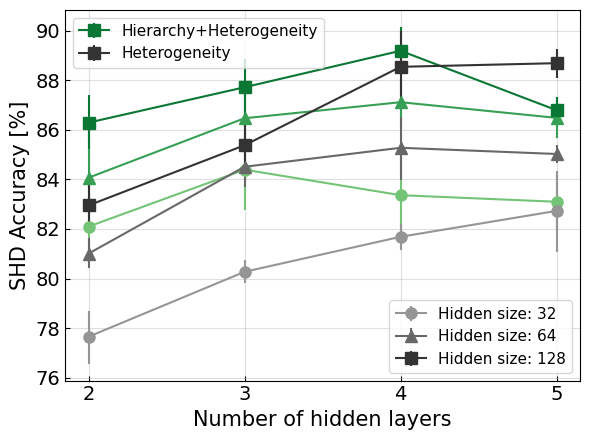

In [139]:
### Number of Layers
# load file
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
file_dir = '/Users/filippomoro/Documents/hsnn/results'
file_name = os.path.join( file_dir, 'Sweep_N_layers_train_alpha_False_wandb_export_2024-03-25T11_34_57.357+01_00.csv' )
df = pd.read_csv( file_name, delimiter=',' )

fig, ax = plt.subplots( figsize=(6,4.5) )
n_layers_list = np.sort( list( set( list(df['n_layers'] ) ) ) )
n_hid_list = np.sort( list( set( list(df['n_hid'] ) ) ) )
# delete unnecessary datapoints
n_hid_list = np.delete( n_hid_list, n_hid_list==256 )
n_hid_list = np.delete( n_hid_list, n_hid_list==512 )
# list of markers
marker_list = ['o', '^', 's', '*', 'X', '+']
# list of colors
cmap_green = plt.get_cmap('Greens')
cmap_blues = plt.get_cmap('Grays')
plots_hierarchy, plots_hetero = [], []
for h, n_hid in enumerate(n_hid_list):
    # Heterogeneity
    mean_acc_n_layers = np.array( [ df['Test Acc'][df['n_layers']==tau][df['hierarchy_tau']==True][df['n_hid']==n_hid].mean() for tau in n_layers_list] )
    max_acc_n_layers  = np.array( [ df['Test Acc'][df['n_layers']==tau][df['hierarchy_tau']==True][df['n_hid']==n_hid].quantile(0.85) for tau in n_layers_list] )
    min_acc_n_layers  = np.array( [ df['Test Acc'][df['n_layers']==tau][df['hierarchy_tau']==True][df['n_hid']==n_hid].quantile(0.15) for tau in n_layers_list] )
    # Homogeneity
    mean_acc_n_layers_hom = np.array( [ df['Test Acc'][df['n_layers']==tau][df['hierarchy_tau']==False][df['n_hid']==n_hid].mean() for tau in n_layers_list] )
    max_acc_n_layers_hom  = np.array( [ df['Test Acc'][df['n_layers']==tau][df['hierarchy_tau']==False][df['n_hid']==n_hid].quantile(0.85) for tau in n_layers_list] )
    min_acc_n_layers_hom  = np.array( [ df['Test Acc'][df['n_layers']==tau][df['hierarchy_tau']==False][df['n_hid']==n_hid].quantile(0.15) for tau in n_layers_list] )

    # Heterogeneity
    # ax.plot( n_layers_list, mean_acc_n_layers, color=cmap_green(int(128+128*h/len(n_hid_list))), marker=marker_list[h], ms=8, label=r'Hierarchy $\tau$ H:'+str(n_hid) )
    # ax.fill_between( n_layers_list, min_acc_n_layers, max_acc_n_layers, color='tab:green', alpha=0.0 )
    yerr_list = [mean_acc_n_layers-min_acc_n_layers, max_acc_n_layers-mean_acc_n_layers]
    hierarchy_plot = ax.errorbar( n_layers_list, mean_acc_n_layers, yerr=yerr_list, 
                 color=cmap_green(int(128+128*h/len(n_hid_list))), 
                 marker=marker_list[h], ms=8, 
                 label=r'Hierarchy $\tau$ H:'+str(n_hid))
    plots_hierarchy.append( hierarchy_plot )
    # Homogeneity
    yerr_list = [mean_acc_n_layers_hom-min_acc_n_layers_hom, max_acc_n_layers_hom-mean_acc_n_layers_hom]
    # ax.plot( n_layers_list, mean_acc_n_layers_hom, color=cmap_blues(int(128+128*h/len(n_hid_list))), marker=marker_list[h], ms=8, label=r'Heterogeneity $\tau$ H:'+str(n_hid) )
    # ax.fill_between( n_layers_list, min_acc_n_layers_hom, max_acc_n_layers_hom, color='tab:blue', alpha=0.0 )
    heterogeneous_plot = ax.errorbar( n_layers_list, mean_acc_n_layers_hom, yerr=yerr_list, 
                 color=cmap_blues(int(128+128*h/len(n_hid_list))), 
                 marker=marker_list[h], ms=8, 
                 label=r'Hierarchy $\tau$ H:'+str(n_hid))
    plots_hetero.append( heterogeneous_plot )

ax.set_xlabel('Number of hidden layers', size=15); ax.set_ylabel('SHD Accuracy [%]', size=15)
ax.set_xticks( n_layers_list, n_layers_list-1 )
ax.tick_params( direction='in', labelsize=14 )
# legend
legend1 = ax.legend(prop={'size':11}, loc=2, handles=[plots_hierarchy[-1], plots_hetero[-1]], labels=['Hierarchy+Heterogeneity', 'Heterogeneity'])
legend2 = ax.legend(prop={'size':11}, loc=4, handles=plots_hetero, labels=['Hidden size: '+str(n_hid) for n_hid in n_hid_list])
pyplot.gca().add_artist(legend1)
ax.grid(alpha=0.4)
plt.tight_layout()
fig.savefig( os.path.join( os.getcwd(), 'results/Sweep_n_layers.pdf' ), dpi=300, transparent=True )

In [9]:
### Tau FF: Hidden
args.train_alpha = False
args.hierarchy_tau = False
args.distrib_tau = True
args.distrib_tau_bittar = False
args.recurrent = False
args.normalizer = None # 'batch' #'layer'
args.norm_bias_init = 0.3
if args.normalizer == 'batch': norm = BatchNorm
elif args.normalizer == 'layer': norm = LayerNorm
else: norm = None
# network architecture
if args.recurrent: model = hrsnn_step
else: model = hsnn_step
args.n_layers = 3
args.n_hid = 128
# time constants
args.tau_mem = 0.3 #0.1
delta_tau = 0.1
args.tau_end = args.tau_mem + delta_tau
args.tau_start = args.tau_mem - delta_tau
if args.recurrent: args.tau_out = 0.1
else: args.tau_out = 0.1 # 0.21 #0.01
# weight init
### 0.3 for FF, 0.1 for Rec
if args.recurrent: args.w_scale = [0.075, 0.05]
else : args.w_scale = [ 2*np.sqrt(1/args.n_in), 2*np.sqrt(1/args.n_hid), 2*np.sqrt(1/args.n_hid) ] #[0.3]*args.n_layers
# LR and regularizers
if args.recurrent: args.lr = 0.001
else: args.lr = 0.01
args.lr_decay = 0.5
args.lr_decay_every = 50
args.l2_lambda = 1e-5
args.freq_lambda = 0 #1e-5
args.dropout_rate = 0.1
n_epochs = 50

tau_list = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
test_acc_shd_list, val_acc_shd_list = [], []
for t, tau in enumerate( tau_list ):
    args.tau_mem = tau
    print(f'-- Tau = {tau*1e3}ms')
    train_loss, test_acc_shd, val_acc_shd, net_params_trained = train_mosaic(key = jax.random.PRNGKey(args.seed), n_batch=args.batch_size, n_epochs=n_epochs, args = args, lr = args.lr, 
                                                            train_dl = train_loader_custom_collate, test_dl = test_loader_custom_collate, val_dl=val_loader_custom_collate,
                                                            model=model, param_initializer=params_initializer, decoder=decoder_sum,
                                                            noise_start_step=10, noise_std=0.1, dataset_name='shd', verbose=False)
    test_acc_shd_list.append( test_acc_shd ), val_acc_shd_list.append( val_acc_shd )
    

-- Tau = 10.0ms
Validation Accuracy: 72.98
Test Accuracy: 61.75
-- Tau = 50.0ms
Validation Accuracy: 78.98
Test Accuracy: 65.33
-- Tau = 100.0ms
Validation Accuracy: 82.23
Test Accuracy: 69.04
-- Tau = 200.0ms
Validation Accuracy: 80.94
Test Accuracy: 67.93
-- Tau = 300.0ms
Validation Accuracy: 86.09
Test Accuracy: 68.02
-- Tau = 500.0ms
Validation Accuracy: 84.80
Test Accuracy: 69.39


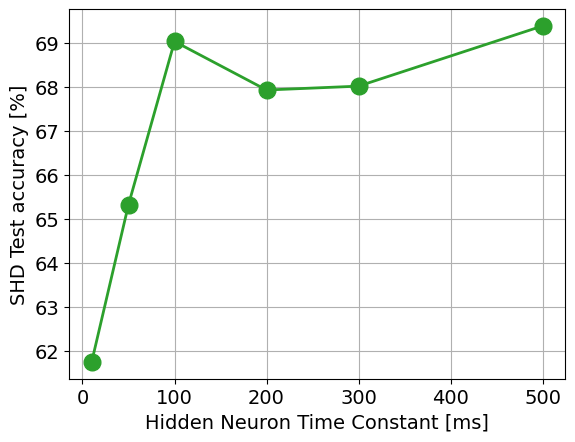

In [10]:
fig, ax = plt.subplots()
tau_list = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
ax.plot( np.array(tau_list)*1e3, test_acc_shd_list, marker='o', color='tab:green', lw=2, markersize=12 )
ax.set_xlabel( 'Hidden Neuron Time Constant [ms]', size=14 )
ax.set_ylabel( 'SHD Test accuracy [%]', size=14 )
ax.tick_params( labelsize=14 )
ax.grid(True)

In [17]:
### Tau FF: output
args.train_alpha = False
args.hierarchy_tau = False
args.distrib_tau = False
args.recurrent = False
# network architecture
if args.recurrent: model = hrsnn_step
else: model = hsnn_step
args.n_layers = 3
args.n_hid = 128
# time constants
args.tau_mem = 0.25 #0.1
args.tau_out = 0.01
# weight init
### 0.3 for FF, 0.1 for Rec
if args.recurrent: args.w_scale = 0.1
else : args.w_scale = 0.3
# LR and regularizers
args.lr = 0.01
args.lr_decay = 0.5
args.lr_decay_every = 50
args.l2_lambda = 5e-5
args.freq_lambda = 5e-5
args.dropout_rate = 0.1
n_epochs = 50

tau_list = [0.001, 0.01, 0.05, 0.1, 0.25]
test_acc_shd_list, val_acc_shd_list = [], []
for t, tau in enumerate( tau_list ):
    args.tau_out = tau
    print(f'-- Tau = {tau*1e3}ms')
    _, test_acc_shd, test_acc_ssc, val_acc_shd, _ = train_mosaic(key = jax.random.PRNGKey(args.seed), n_batch=args.batch_size, n_epochs=n_epochs, args = args, lr = args.lr, 
                                    train_dl = train_loader_custom_collate, test_dl = test_loader_custom_collate, val_dl=val_loader_custom_collate,
                                    model=model, param_initializer=params_initializer, decoder=decoder_sum,
                                    noise_start_step=10, noise_std=0.1, dataset_name='shd', verbose=False)
    test_acc_shd_list.append( test_acc_shd ), val_acc_shd_list.append( val_acc_shd )
    

-- Tau = 1.0ms
SHD Validation Accuracy: 85.85
SHD Test Accuracy: 68.15
-- Tau = 10.0ms
SHD Validation Accuracy: 84.01
SHD Test Accuracy: 70.67
-- Tau = 50.0ms
SHD Validation Accuracy: 83.33
SHD Test Accuracy: 64.58
-- Tau = 100.0ms
SHD Validation Accuracy: 68.69
SHD Test Accuracy: 60.69
-- Tau = 250.0ms
SHD Validation Accuracy: 38.42
SHD Test Accuracy: 35.78


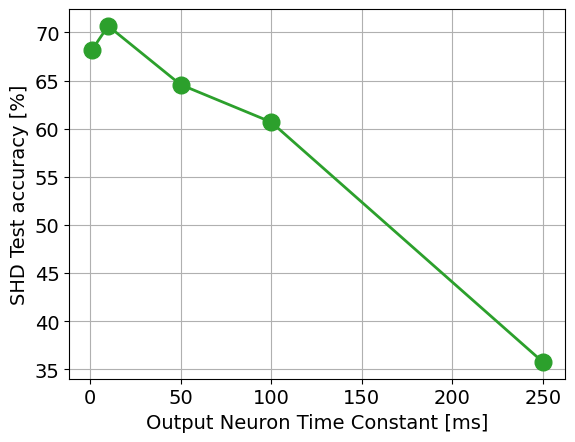

In [18]:
fig, ax = plt.subplots()
tau_list = [0.001, 0.01, 0.05, 0.1, 0.25]
ax.plot( np.array(tau_list)*1e3, test_acc_shd_list, marker='o', color='tab:green', lw=2, markersize=12 )
ax.set_xlabel( 'Output Neuron Time Constant [ms]', size=14 )
ax.set_ylabel( 'SHD Test accuracy [%]', size=14 )
ax.tick_params( labelsize=14 )
ax.grid(True)

In [13]:
# Effect of Tau FF Hierarchy

### Tau FF: Hidden
args.train_alpha = False
args.hierarchy_tau = False
args.distrib_tau = True
args.distrib_tau_bittar = False
args.recurrent = False
args.normalizer = None # 'batch' #'layer'
args.norm_bias_init = 0.3
if args.normalizer == 'batch': norm = BatchNorm
elif args.normalizer == 'layer': norm = LayerNorm
else: norm = None
# network architecture
if args.recurrent: model = hrsnn_step
else: model = hsnn_step
args.n_layers = 3
args.n_hid = 128
# time constants
args.tau_mem = 0.1 #0.1
delta_tau = 0.1
args.tau_end = args.tau_mem + delta_tau
args.tau_start = args.tau_mem - delta_tau
if args.recurrent: args.tau_out = 0.1
else: args.tau_out = 0.1 # 0.21 #0.01
# weight init
### 0.3 for FF, 0.1 for Rec
if args.recurrent: args.w_scale = [0.075, 0.05]
else : args.w_scale = [ np.sqrt(1/args.n_in), np.sqrt(1/args.n_hid), np.sqrt(1/args.n_hid) ] #[0.3]*args.n_layers
# LR and regularizers
if args.recurrent: args.lr = 0.001
else: args.lr = 0.01
args.lr_decay = 0.5
args.lr_decay_every = 50
args.l2_lambda = 1e-5
args.freq_lambda = 0 #1e-5
args.dropout_rate = 0.1
n_epochs = 50

tau_list = [0.01, 0.05, 0.1, 0.2]
test_acc_shd_list, val_acc_shd_list = [], []
for t, tau in enumerate( tau_list ):
    args.tau_end = args.tau_mem + tau
    args.tau_start = args.tau_mem - tau
    print(f'-- Delta Tau = {tau*1e3}ms')
    train_loss, test_acc_shd, val_acc_shd, net_params_trained = train_mosaic(key = jax.random.PRNGKey(args.seed), n_batch=args.batch_size, n_epochs=n_epochs, args = args, lr = args.lr, 
                                                            train_dl = train_loader_custom_collate, test_dl = test_loader_custom_collate, val_dl=val_loader_custom_collate,
                                                            model=model, param_initializer=params_initializer, decoder=decoder_sum,
                                                            noise_start_step=10, noise_std=0.1, dataset_name='shd', verbose=False)
    test_acc_shd_list.append( test_acc_shd ), val_acc_shd_list.append( val_acc_shd )
    

-- Delta Tau = 10.0ms
Validation Accuracy: 84.31
Test Accuracy: 68.82
-- Delta Tau = 50.0ms
Validation Accuracy: 83.09
Test Accuracy: 69.52
-- Delta Tau = 100.0ms
Validation Accuracy: 82.05
Test Accuracy: 67.09
-- Delta Tau = 200.0ms
Validation Accuracy: 83.21
Test Accuracy: 70.14


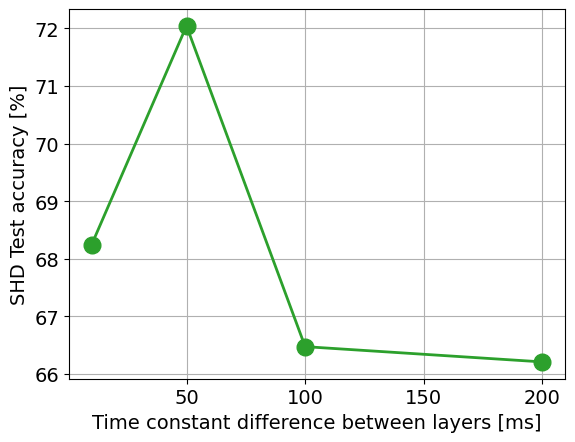

In [12]:
fig, ax = plt.subplots()
tau_list = [0.01, 0.05, 0.1, 0.2]
ax.plot( np.array(tau_list)*1e3, test_acc_shd_list, marker='o', color='tab:green', lw=2, markersize=12 )
ax.set_xlabel( 'Time constant difference between layers [ms]', size=14 )
ax.set_ylabel( 'SHD Test accuracy [%]', size=14 )
ax.tick_params( labelsize=14 )
ax.grid(True)